In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
# def generateGaussians(sample_size, corr, means):
#     mean = means
#     cov = [[1, corr], [corr, 1]]
#     return np.random.multivariate_normal(mean, cov, sample_size)

def generateGaussians(sample_size, corr, means=None):
    cov = [[0.1, corr], [corr, 0.1]]
    X0 = np.random.multivariate_normal(means[0], cov, sample_size)
    X1 = np.random.multivariate_normal(means[1], cov, sample_size)
    X2 = np.random.multivariate_normal(means[2], cov, sample_size)
    X3 = np.random.multivariate_normal(means[3], cov, sample_size)
    
    tmp = np.vstack((X0, X1))
    tmp = np.vstack((tmp, X2))
    tmp = np.vstack((tmp, X3))
    
    X0_out = makeOutput(X0).reshape((sample_size, 1))
    X1_out = -makeOutput(X1).reshape((sample_size, 1))
    X2_out = -makeOutput(X2).reshape((sample_size, 1))
    X3_out = makeOutput(X3).reshape((sample_size, 1))
    
    tmp2 = np.vstack((X0_out, X1_out))
    tmp2 = np.vstack((tmp2, X2_out))
    tmp2 = np.vstack((tmp2, X3_out))
        
    return tmp, tmp2

In [3]:
def makeOutput(x):
    return np.sum(np.abs(x), axis=1)

In [23]:
def plot_distributions(x1, x2, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].scatter(x1[:,0], x1[:,1], s=50)
    ax[1].scatter(x2[:,0], x2[:,1], s=50)

    ax[0].set_xlim([-10, 10])
    ax[0].set_ylim([-10, 10])
    ax[1].set_xlim([-10, 10])
    ax[1].set_ylim([-10, 10])
    
    ax[0].set_title('Task 1')
    ax[1].set_title('Task 2')

    plt.tight_layout()
    plt.show()

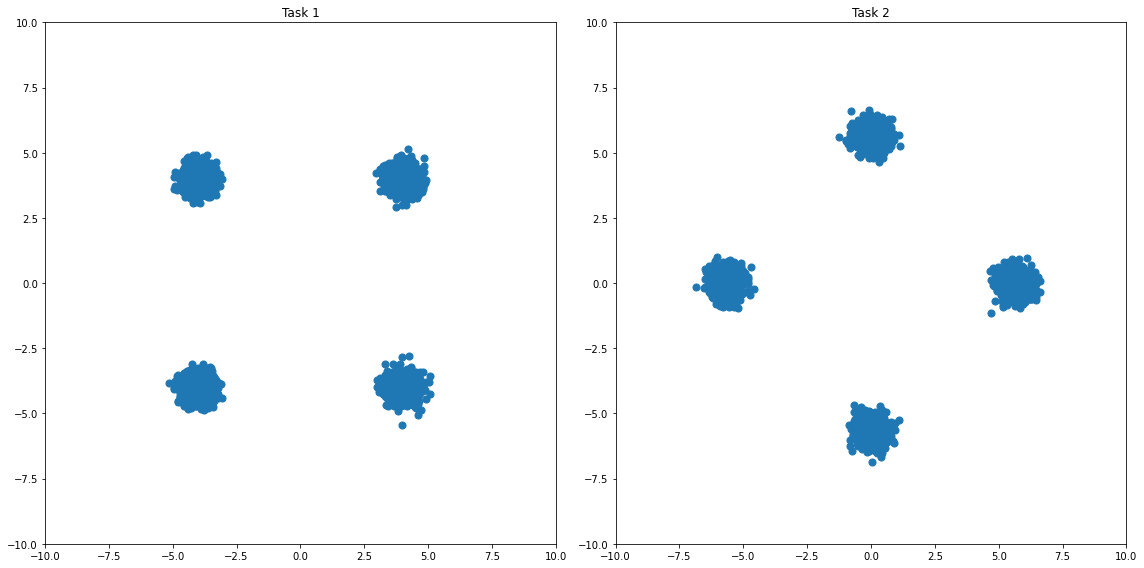

Text(0.5, 0.92, 'Task 2: L1 distance')

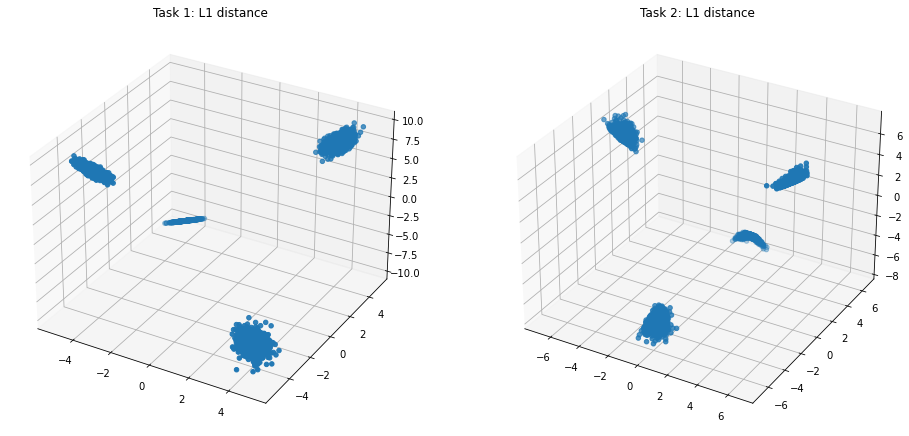

In [24]:
means_1 = [[-4,-4], [-4,4], [4,-4], [4,4]]
means_2 = [[-4*np.sqrt(2),0],[0,-4*np.sqrt(2)],[0,4*np.sqrt(2)],[4*np.sqrt(2),0]]

X1, Z1 = generateGaussians((1000), 0, means_1)
X2, Z2 = generateGaussians((1000), 0, means_2)

# plot and format:
plot_distributions(X1, X2, ['Task 1', 'Task 2'])

fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter3D(X1[:,0],X1[:,1], Z1)
ax1.set_title('Task 1: L1 distance')

ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter3D(X2[:,0],X2[:,1], Z2)
ax2.set_title('Task 2: L1 distance')

In [6]:
def experiment(n_pos, n_neg, n_test, n_trees, max_depth, corr, means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets,
    # y=x and y=-x have been given.
    if n_pos == 0 and n_neg == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, we need two errors,
    # one for task 1 (y=x) and one for task 2 (y=-x)
    errors = np.zeros(2, dtype=float)

    # Initialize the transformer type and arguments
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    # Initialize the voter type and arguments
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    # Initialize the decider type and arguments
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    # Initialize the progressive learner using the transformer, voter,
    # and decider classes
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets for the linear expressions and their test sets
    if (n_pos != 0):
        X1,Z1 = generateGaussians(n_pos, corr, means_1)
        X1_test,Z1_test = generateGaussians(n_test, corr, means_1)

    if (n_neg != 0):
        X2,Z2 = generateGaussians(n_neg, -corr, means_2)
        X2_test,Z2_test = generateGaussians(n_test, -corr, means_2)
    
    #####################################################################
    # Start training and predicting with the progressive learner
    #####################################################################
    # If there is no sample size for y=x, then only add a task for y=-x, predict
    # the probabilities and add the errors to the error array
    if (n_pos == 0 and n_neg != 0):
        # Add task to progressive learner
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)

        errors[0] = 1.0
        errors[1] = mean_squared_error(predicted_Z2, Z2_test)
    
    # If there is no sample size for y=-x, then only add a task for y=x, predict
    # the probabilities and add the errors to the error array
    elif (n_neg == 0 and n_pos != 0):
        # Add task to progressive learner
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)

        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        errors[1] = 1.0

    # If both sample sizes are given, add a task for the first dataset, predict
    # the probabilities and add the errors to the error array. Then, add the
    # transformer trained on y=-x and predict the error from there.
    elif (n_neg != 0 and n_pos != 0):
        # Add tasks to progressive learner
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        
        progressive_learner.add_transformer(X2, Z2,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)
        
    return errors

In [7]:
# Set up the tree parameters
mc_rep = 10000
n_test = 1000
n_trees = 10
n_sample_size = 1000
corr = 0
max_depth = 4
means_1 = [[-4,-4], [-4,4], [4,-4], [4,4]]
means_2 = [[-4*np.sqrt(2),0],[0,-4*np.sqrt(2)],[0,4*np.sqrt(2)],[4*np.sqrt(2),0]]

# Sample sizes for y=x and y=-x
n_pos = (100*np.arange(0.5, 7.75, step=0.50)).astype(int)
n_neg = (100*np.arange(0.5, 7.75, step=0.50)).astype(int)

In [8]:
# Initiate error arrays
mean_error = np.zeros((2, len(n_pos) + len(n_neg)))
std_error = np.zeros((2, len(n_pos) + len(n_neg)))

# Initiate transfer efficiency arrays
mean_te = np.zeros((1, len(n_pos) + len(n_neg)))

#####################################################################
# Iterate over the sample sizes.
#####################################################################
# Start with only task 1 (y=x) dataset and calculate the mean squared error 
# for only one task. Then, when we reach the end of the sample size for y=x,
# we use the maximum sample size for task 1 and see how BTE and FTE change 
# when we iterate over the sample size for task 2 (y=-x). 
for i, n1 in enumerate(n_pos):
    print('starting to compute y=x, sample size=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                n1, 0, n_test, n_trees,max_depth, corr, means_1, means_2) for _ in range(mc_rep)
            )
        )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0]/error[:,1])
    
    if n1==n_pos[-1]:
        for j,n2 in enumerate(n_neg):
            print('starting to compute y=-x, sample size=%s\n'%n2)
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                    delayed(experiment)(n1,n2,n_test,n_trees, max_depth, corr,means_1, means_2) for _ in range(mc_rep)
                )
            )
            # extract relevant data and store in arrays
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = mean_error[0,i] / mean_error[1,i+j+1]
            
mean_bte = mean_te

starting to compute y=x, sample size=50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 4956 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 8556 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=100



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   55.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=150



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 3256 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 6056 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   59.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=200



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=250



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=300



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   56.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=350



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=400



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 5720 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 9320 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   56.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=450



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   54.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=500



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=550



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=600



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 4264 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 7864 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=650



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=700



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=750



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 5952 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 9552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=50



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=100



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=150



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=200



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=250



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 8224 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9724 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=300



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7704 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9604 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed:  3.6min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=350



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=400



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=450



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=500



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=550



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 2708 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3808 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5108 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8308 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=600



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=650



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=700



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=750



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.0min finished


No handles with labels found to put in legend.


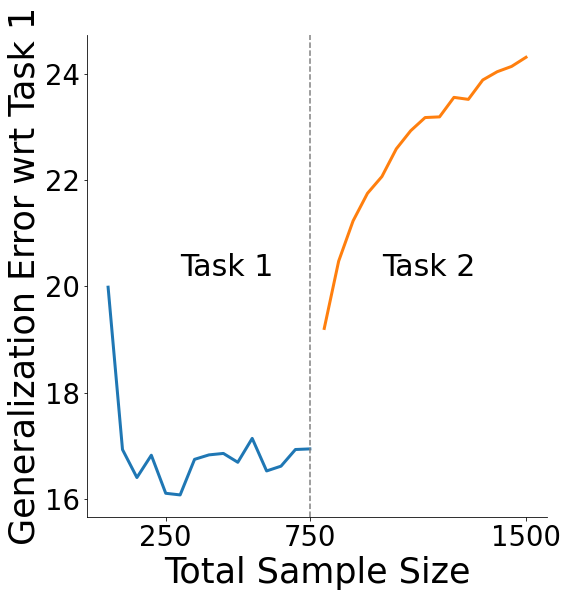

In [9]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
y1_vals = mean_error[0]
y2_vals = mean_error[1]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(n_pos, mean_error[0][0:len(n_pos)], ls="-", lw=3)
ax1.plot(n_neg + n_pos[-1], mean_error[1][len(n_pos):], ls="-", lw=3)

ax1.set_ylabel("Generalization Error wrt Task 1", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
# ax1.set_ylim([0, 0.75])
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

In [10]:
print(mean_error)

[[19.98373708 16.92661974 16.40017939 16.82051021 16.10362724 16.07302314
  16.74274015 16.82671941 16.85414203 16.68730634 17.1374293  16.5242683
  16.61438991 16.92791504 16.93934945 16.98720513 17.16267604 17.07335941
  16.73047913 16.7932172  16.91037586 17.00256979 17.1112965  16.78135303
  17.10368806 16.76913381 17.09317402 17.12776195 17.18004448 17.33967741]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.         19.20772845 20.47396838 21.23098915
  21.75088183 22.06597516 22.58777584 22.92934094 23.17719981 23.18996658
  23.55715831 23.51948433 23.88444038 24.0397829  24.13976596 24.31178444]]


No handles with labels found to put in legend.


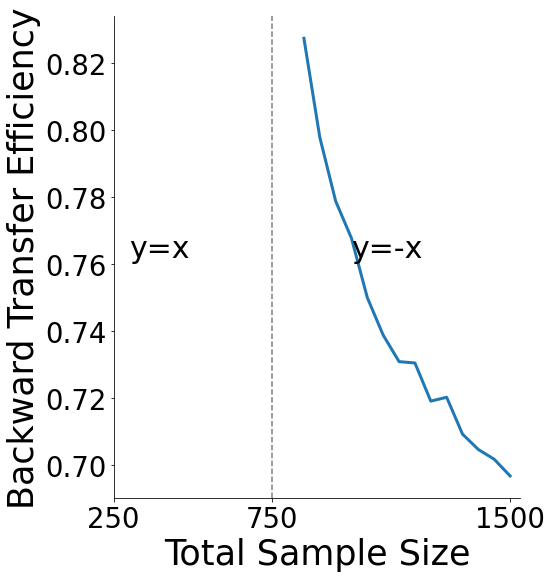

In [11]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
y1_vals = mean_bte[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals[len(n_pos)+1:], y1_vals[len(n_pos)+1:], ls="-", lw=3)

ax1.set_ylabel("Backward Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

In [12]:
print(mean_bte)

[[19.98373708 16.92661974 16.40017939 16.82051021 16.10362724 16.07302314
  16.74274015 16.82671941 16.85414203 16.68730634 17.1374293  16.5242683
  16.61438991 16.92791504 16.93934945  0.8819028   0.82736034  0.79785964
   0.77878909  0.76766829  0.74993437  0.73876303  0.73086264  0.73046028
   0.7190744   0.72022623  0.70922112  0.7046382   0.7017197   0.69675467]]


In [13]:
def experiment(n_pos, n_neg, n_test, n_trees, max_depth, corr, means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets,
    # y=x and y=-x have been given.
    if n_pos == 0 and n_neg == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, we need two errors,
    # one for task 1 (y=x) and one for task 2 (y=-x)
    errors = np.zeros(2, dtype=float)
    
    # Initialize the transformer type and arguments
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    
    # Initialize the voter type and arguments
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}
    
    # Initialize the decider type and arguments
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}
    
    # Initialize the progressive learner using the transformer, voter,
    # and decider classes
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets for the linear expressions and their test sets
    if (n_pos != 0):
        X1,Z1 = generateGaussians(n_pos, corr, means_1)
        X1_test,Z1_test = generateGaussians(n_test, corr, means_1)
        
    if (n_neg != 0):
        X2,Z2 = generateGaussians(n_neg, -corr, means_2)
        X2_test,Z2_test = generateGaussians(n_test, -corr, means_2)
    
    #####################################################################
    # Start training and predicting with the progressive learner
    #####################################################################     
    # If both sample sizes are given, add a task for the first dataset, predict
    # the probabilities and add the errors to the error array. Then, add the
    # transformer trained on y=-x and predict the error from there.
    if (n_neg != 0 and n_pos != 0):
        # Add tasks to progressive learner
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z2, Z2_test)
        
        progressive_learner.add_transformer(X1, Z1,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z2, Z2_test)
        
    return errors

In [14]:
# Initiate error arrays
mean_error = np.zeros((2, len(n_neg)))
std_error = np.zeros((2, len(n_neg)))

# Initiate transfer efficiency arrays
mean_te = np.zeros((1, len(n_neg)))

#####################################################################
# Iterate over the sample sizes.
#####################################################################
# Start with only task 1 (y=x) dataset and calculate the mean squared error 
# for only one task. Then, when we reach the end of the sample size for y=x,
# we use the maximum sample size for task 1 and see how BTE and FTE change 
# when we iterate over the sample size for task 2 (y=-x).

for j,n2 in enumerate(n_neg):
    print('starting to compute y=-x, sample size=%s\n'%n2)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
            delayed(experiment)(750,n2,n_test,n_trees,max_depth, corr, means_1, means_2) for _ in range(mc_rep)
        )
    )
    # extract relevant data and store in arrays
    mean_error[:,j] = np.mean(error,axis=0)
    std_error[:,j] = np.std(error,ddof=1,axis=0)
    mean_te[0,j] = mean_error[0,j] / mean_error[1,j]

mean_fte = mean_te

starting to compute y=-x, sample size=50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=100



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=150



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=200



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=250



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=300



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=350



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=400



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=450



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=500



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=550



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=600



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=650



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=700



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=750



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1228 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 2828 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3928 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5228 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6728 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8428 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  3.1min finished


No handles with labels found to put in legend.


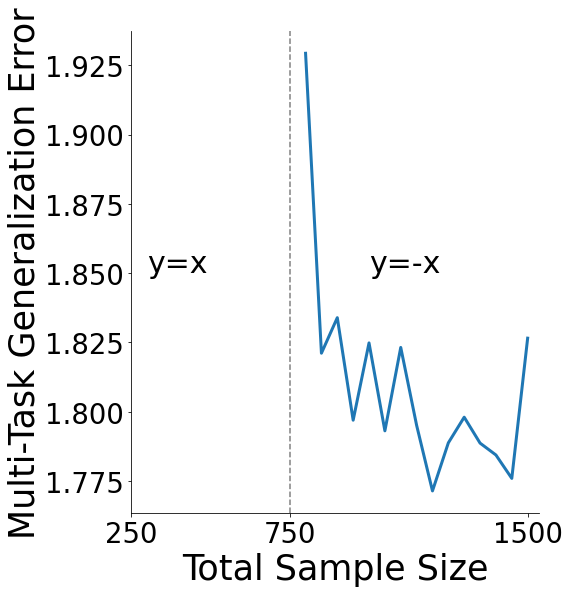

In [15]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = n_neg + n_pos[-1]
y1_vals = mean_error[1]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Multi-Task Generalization Error", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

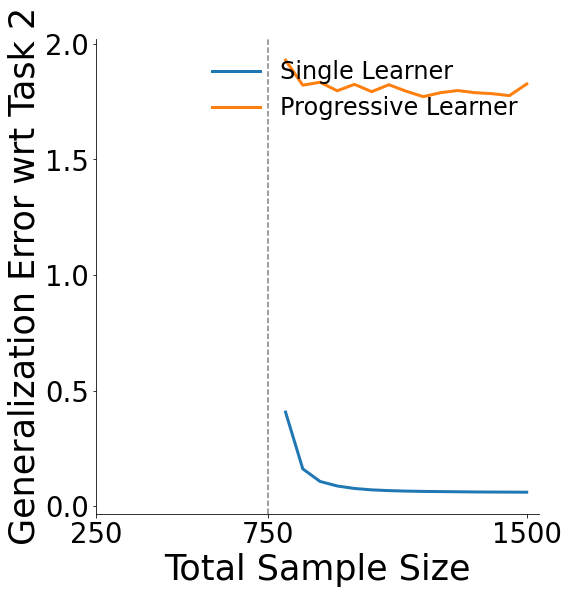

In [16]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

label=['Single Learner', 'Progressive Learner']

x_vals = n_neg + n_pos[-1]
y1_vals = mean_error[0]
y2_vals = mean_error[1]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(x_vals, y1_vals, ls="-", lw=3)
ax.plot(x_vals, y2_vals, ls="-", lw=3)

ax.set_ylabel("Generalization Error wrt Task 2", fontsize=35)

ax.legend(label, loc="upper right", fontsize=24, frameon=False)
ax.set_xlabel("Total Sample Size", fontsize=35)

ax.tick_params(labelsize=27.5)
ax.set_xticks([250, 750, 1500])

ax.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")

right_side = ax.spines["right"]

right_side.set_visible(False)
top_side = ax.spines["top"]

top_side.set_visible(False)
# ax.text(300, np.mean(ax.get_ylim()), "%s"%(TASK1), fontsize=30)
# ax.text(1000, np.mean(ax.get_ylim()), "%s"%(TASK2), fontsize=30)

plt.tight_layout()

No handles with labels found to put in legend.


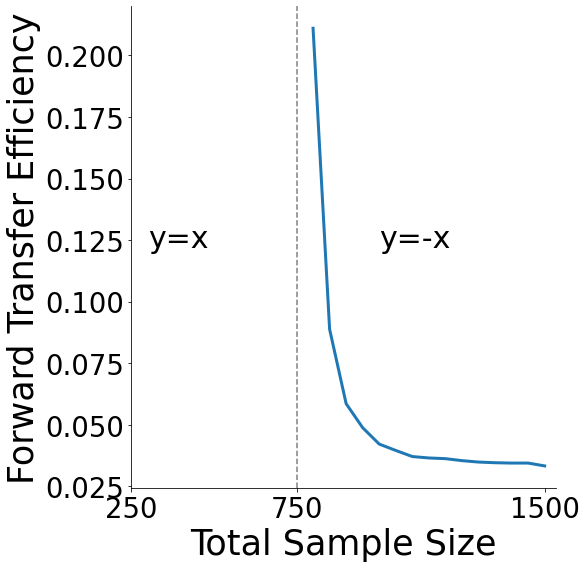

In [17]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = n_neg + n_pos[-1]
y1_vals = mean_te[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Forward Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

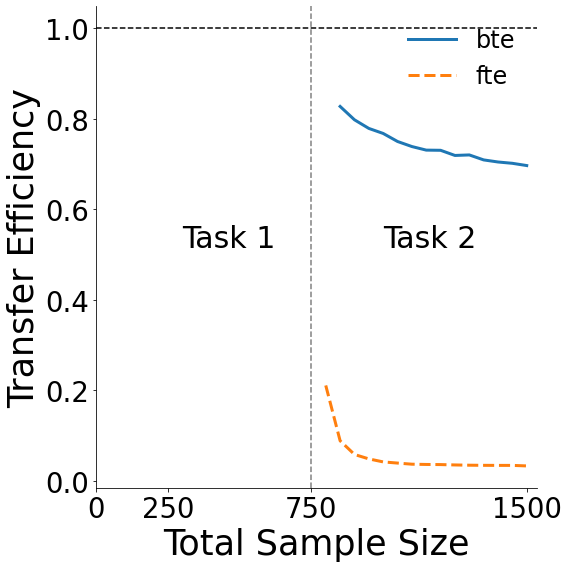

In [18]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

# x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
# x_vals = n_neg + n_pos[-1]

y1_vals = mean_bte[0]
y2_vals = mean_fte[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(np.concatenate((n_pos, n_neg + n_pos[-1]))[len(n_pos)+1:], y1_vals[len(n_pos)+1:], ls="-", lw=3, label="bte")

ax1.plot((n_neg + n_pos[-1]), y2_vals, ls="dashed", lw=3, label="fte")

ax1.set_ylabel("Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([0, 250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
ax1.axhline(y=1.0, c="black", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()